
# IFCD104 – Tema 2: Autoencoder con Keras (MNIST)

Este cuaderno implementa un **autoencoder** sencillo para **reconstruir imágenes** del dataset **MNIST**.  
Incluye:
- Carga y **preprocesado** de datos.
- Construcción de un **autoencoder** `Encoder → Latent → Decoder`.
- **Entrenamiento** y **curvas de pérdida**.
- Visualización **original vs reconstruido**.
- Variante **Denoising Autoencoder** (opcional) añadiendo ruido a las entradas.
- Guardado y carga del modelo en formato `.keras` (ruta **local**).


## 1) Importaciones

In [1]:

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Utilidades
def show_images_grid(images, titles=None, nrows=2, ncols=8, suptitle=None):
    plt.figure(figsize=(ncols*1.2, nrows*1.2))
    idx = np.random.choice(len(images), size=nrows*ncols, replace=False)
    for i, j in enumerate(idx, start=1):
        plt.subplot(nrows, ncols, i)
        plt.imshow(images[j].squeeze(), cmap='gray')
        if titles is not None:
            plt.title(str(titles[j]))
        plt.axis('off')
    if suptitle:
        plt.suptitle(suptitle)
    plt.show()


## 2) Carga y preprocesado de MNIST

Shapes -> train: (60000, 28, 28, 1)  test: (10000, 28, 28, 1)


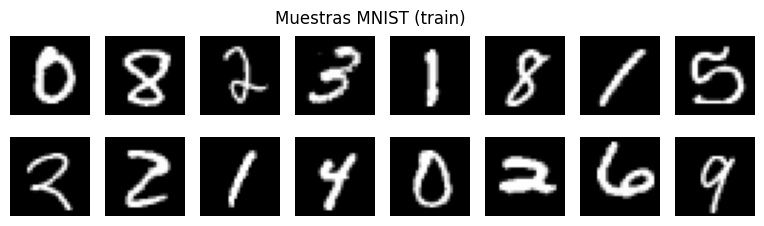

In [2]:

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalizar a [0,1] y añadir canal (1)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)  # (N, 28, 28, 1)
x_test  = np.expand_dims(x_test, -1)

print("Shapes -> train:", x_train.shape, " test:", x_test.shape)

# Muestra rápida
show_images_grid(x_train, suptitle="Muestras MNIST (train)")



## 3) Definición del Autoencoder
Arquitectura compacta y didáctica:
- **Encoder**: Conv→Pool→Conv→Pool→Flatten→Dense(latent)
- **Latent**: dimensión 32
- **Decoder**: Dense→Reshape→ConvTranspose→UpSampling→Conv(sigmoid)

> *Nota*: Para reconstrucción, usamos `loss='binary_crossentropy'` con imágenes normalizadas en `[0,1]`.


In [3]:

latent_dim = 32

# Encoder
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name='latent')(x)

# Decoder
x = layers.Dense(7*7*64, activation='relu')(latent)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(inputs, outputs, name="mnist_autoencoder")
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "mnist_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,369 (1.06 MB)

 Trainable params: 278,369 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

## 4) Entrenamiento

In [4]:

history = autoencoder.fit(
    x_train, x_train,            # objetivo: reconstruir la propia entrada
    validation_split=0.1,
    epochs=5,                    # aumenta si quieres mejor reconstrucción
    batch_size=128,
    verbose=1
)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.1597 - val_loss: 0.0942
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.0868 - val_loss: 0.0831
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.0800 - val_loss: 0.0788
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.0771 - val_loss: 0.0770
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.0755 - val_loss: 0.0767


## 5) Curvas de pérdida

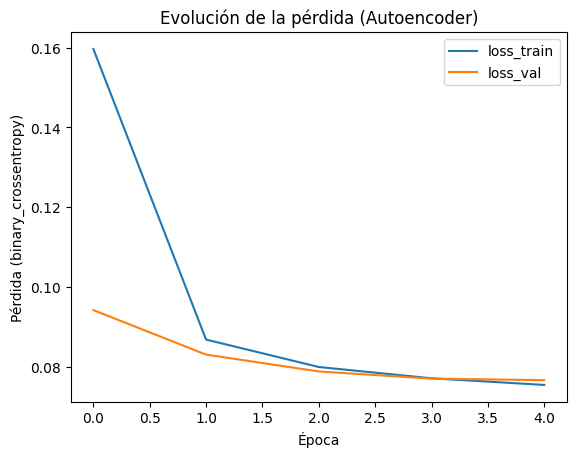

In [5]:

plt.figure()
plt.plot(history.history['loss'], label='loss_train')
plt.plot(history.history['val_loss'], label='loss_val')
plt.xlabel("Época")
plt.ylabel("Pérdida (binary_crossentropy)")
plt.title("Evolución de la pérdida (Autoencoder)")
plt.legend()
plt.show()


## 6) Reconstrucciones en test

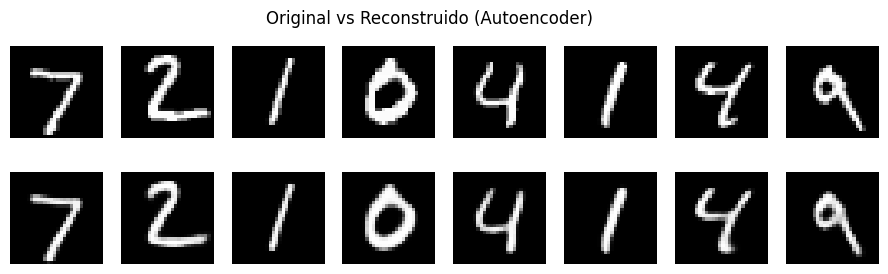

MSE medio de reconstrucción (2k test): 0.004812677390873432


In [6]:

# Reconstrucciones
x_test_pred = autoencoder.predict(x_test[:2000], verbose=0)

# Mostrar originales y reconstrucciones
n = 8
plt.figure(figsize=(n*1.4, 3))
for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Original")
    # Reconstruido
    plt.subplot(2, n, n+i+1)
    plt.imshow(x_test_pred[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Reconstruido")
plt.suptitle("Original vs Reconstruido (Autoencoder)")
plt.show()

# Error de reconstrucción medio (MSE) en 2k ejemplos
mse = np.mean((x_test_pred - x_test[:2000])**2)
print("MSE medio de reconstrucción (2k test):", float(mse))



## 7) Denoising Autoencoder (opcional)
Agregamos **ruido gaussiano** a la entrada y entrenamos para reconstruir la **imagen limpia**.


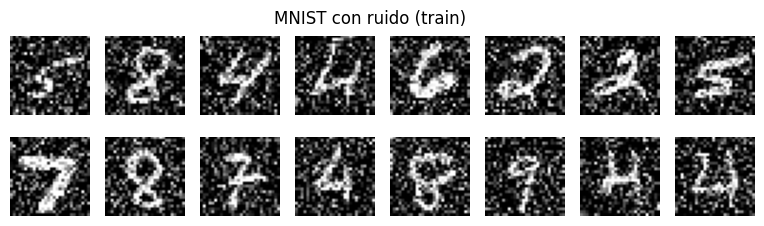

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.1998 - val_loss: 0.1183
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.1068 - val_loss: 0.1010
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.0974 - val_loss: 0.0963


In [16]:

noise_std = 0.4
x_train_noisy = np.clip(x_train + noise_std*np.random.normal(size=x_train.shape), 0., 1.)
x_test_noisy  = np.clip(x_test  + noise_std*np.random.normal(size=x_test.shape),  0., 1.)

# Muestra con ruido
show_images_grid(x_train_noisy, suptitle="MNIST con ruido (train)")

# Entrenamos un modelo idéntico desde cero para denoising
inputs_n = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs_n)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
latent_n = layers.Dense(latent_dim, name='latent_n')(x)

x = layers.Dense(7*7*64, activation='relu')(latent_n)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
outputs_n = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

denoiser = keras.Model(inputs_n, outputs_n, name="mnist_denoiser")
denoiser.compile(optimizer='adam', loss='binary_crossentropy')

history_d = denoiser.fit(
    x_train_noisy, x_train,
    validation_split=0.1,
    epochs=3,
    batch_size=128,
    verbose=1
)


## 8) Resultados del Denoiser

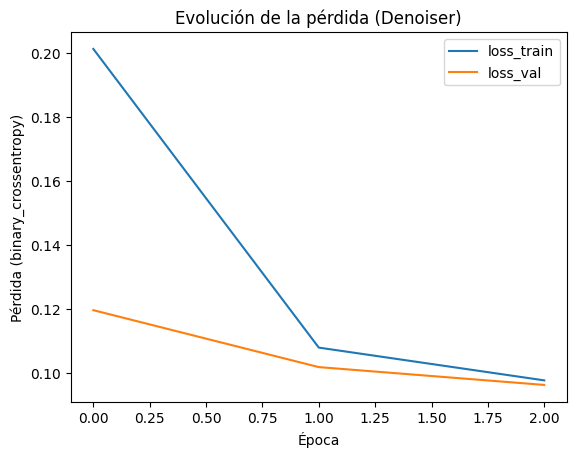

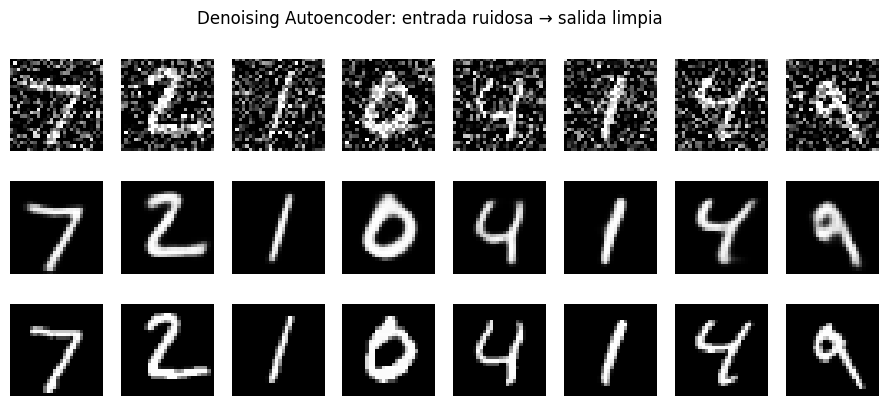

In [8]:

plt.figure()
plt.plot(history_d.history['loss'], label='loss_train')
plt.plot(history_d.history['val_loss'], label='loss_val')
plt.xlabel("Época")
plt.ylabel("Pérdida (binary_crossentropy)")
plt.title("Evolución de la pérdida (Denoiser)")
plt.legend()
plt.show()

# Reconstrucciones desde imágenes ruidosas
x_test_denoised = denoiser.predict(x_test_noisy[:2000], verbose=0)

n = 8
plt.figure(figsize=(n*1.4, 4.5))
for i in range(n):
    # Ruidosa
    plt.subplot(3, n, i+1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Ruidosa")
    # Denoised
    plt.subplot(3, n, n+i+1)
    plt.imshow(x_test_denoised[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Denoised")
    # Original
    plt.subplot(3, n, 2*n+i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Original")
plt.suptitle("Denoising Autoencoder: entrada ruidosa → salida limpia")
plt.show()


## 9) Guardar y cargar modelos (ruta local)

In [9]:

ae_path = "mnist_autoencoder.keras"
denoiser_path = "mnist_denoiser.keras"

autoencoder.save(ae_path)
denoiser.save(denoiser_path)

print("Modelos guardados en:", ae_path, "y", denoiser_path)

autoencoder_loaded = keras.models.load_model(ae_path)
denoiser_loaded = keras.models.load_model(denoiser_path)

# Prueba rápida de carga
loss_loaded = autoencoder_loaded.evaluate(x_test, autoencoder_loaded.predict(x_test, verbose=0), verbose=0)
print("Autoencoder cargado, pérdida (auto-reconstrucción evaluada manualmente):", float(loss_loaded))


Modelos guardados en: mnist_autoencoder.keras y mnist_denoiser.keras
Autoencoder cargado, pérdida (auto-reconstrucción evaluada manualmente): 0.07482249289751053
